## FSL GLM Automatic

### Author: Marc Biosca

### Matrices and Contrast Generation

In [2]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import subprocess
from glob import glob
from fsl import nets
import matplotlib.pyplot as plt
import json
from fsl.nets.load import TimeSeries
from scipy import stats

In [3]:
# CSV Data Path (Update this path to your CSV file)
csv_path = '/home/biofisica/Escritorio/melodic_output_rand_3/data_fslnets.csv' 

# Read CSV Data
df_csv = pd.read_csv(csv_path)


In [4]:
interest_var = 'PTAGE'

group_var = '' # 'Tau' or '' if you don't want to group by any variable

EVs = [interest_var, 'centiloid', 'PTGENDER'] # EVs to include in the model (up to 4)

permutations = 5000 # Number of permutations of randomise

contrasts = [
    '1.0\t0\t0\n',
    '-1.0\t0\t0\n',
]

NumWaves = len(EVs)
NumContrasts = len(contrasts)

In [5]:
# Check if all subjects have the variable of interest

if group_var == '':
    N_subjects = df_csv[interest_var].count()

    if N_subjects != 897:
        all = False
    else:
        all = True
else:
    all = False
    N_subjects = len(df_csv[df_csv[group_var]==1])

print('Number of subjects: ', N_subjects)

Number of subjects:  897


In [6]:
# Configuration Parameters
n_sujetos = str(N_subjects)

# Paths UPDATE
route_list_files = '/home/biofisica/Escritorio/melodic_output_rand_3/my_list_yes_897.txt'
path_melodic = '/home/biofisica/Escritorio/melodic_output_rand_3'


# Read List of Subject Files
with open(route_list_files, 'r') as f:
    list_paths = f.read().splitlines()


# Check if all subjects have the variable of interest
if all:
    indices = [i for i in range(N_subjects)]
elif group_var is not None:
    indices = [i for i, x in enumerate(df_csv[group_var].tolist()) if x == 1]
else:
    print('Error: No valid group variable or tau_bool is False')
    exit()
            
# Extract EVs and Demean
if NumWaves == 3:
    ev1 = df_csv[EVs[0]].tolist()
    ev2 = df_csv[EVs[1]].tolist()
    ev3 = df_csv[EVs[2]].tolist()
    ev1 = [ev1[i] for i in indices]
    ev2 = [ev2[i] for i in indices]
    ev3 = [ev3[i] for i in indices]
    ev1 = ev1 - np.mean(ev1)
    ev2 = ev2 - np.mean(ev2)
    ev3 = ev3 - np.mean(ev3)
elif NumWaves == 2:
    ev1 = df_csv[EVs[0]].tolist()
    ev2 = df_csv[EVs[1]].tolist()
    ev3 = None
    ev1 = [ev1[i] for i in indices]
    ev2 = [ev2[i] for i in indices]
    ev1 = ev1 - np.mean(ev1)
    ev2 = ev2 - np.mean(ev2)
elif NumWaves == 4:
    ev1 = df_csv[EVs[0]].tolist()
    ev2 = df_csv[EVs[1]].tolist()
    ev3 = df_csv[EVs[2]].tolist()
    ev4 = df_csv[EVs[3]].tolist()
    ev1 = [ev1[i] for i in indices]
    ev2 = [ev2[i] for i in indices]
    ev3 = [ev3[i] for i in indices]
    ev4 = [ev4[i] for i in indices]
    ev1 = ev1 - np.mean(ev1)
    ev2 = ev2 - np.mean(ev2)
    ev3 = ev3 - np.mean(ev3)
    ev4 = ev4 - np.mean(ev4)
else:
    ev1 = df_csv[EVs[0]].tolist()
    ev1 = [ev1[i] for i in indices]
    ev2 = None
    ev3 = None
    ev1 = ev1 - np.mean(ev1)


# Create Design Matrix Text
glm_design_text = []
glm_design_text.append(f'/NumWaves\t{NumWaves}\n')
glm_design_text.append(f'/NumPoints\t{N_subjects}\n')
glm_design_text.append(f'/PPheights\t' + '\t'.join(['1.0'] * NumWaves) + '\n\n')
glm_design_text.append('/Matrix\n')

# Populate Design Matrix with Subject Variables
for i in range(N_subjects):
    if NumWaves == 3:
        glm_design_text.append(f'{ev1[i]}\t{ev2[i]}\t{ev3[i]}\n')
    elif NumWaves == 2:
        glm_design_text.append(f'{ev1[i]}\t{ev2[i]}\n')
    elif NumWaves == 4:
        glm_design_text.append(f'{ev1[i]}\t{ev2[i]}\t{ev3[i]}\t{ev4[i]}\n')
    else:
        glm_design_text.append(f'1\t{ev1[i]}\n')

# Write Design Matrix to File
name_file_design_mat = os.path.join(path_melodic, f'ica_glm_design_correct_{interest_var}{group_var}_age_gender_demean_{n_sujetos}.mat')   
with open(name_file_design_mat, 'w') as fp:    
    fp.writelines(glm_design_text)

# Create Contrast Matrix Text
glm_contrasts_text = []   
glm_contrasts_text.append('/ContrastName\t one sample test\n')  
glm_contrasts_text.append(f'/NumWaves\t{NumWaves}\n')
glm_contrasts_text.append(f'/NumContrasts\t{NumContrasts}\n')

# Define PPheights and RequiredEffect for Each Contrast
# Adjust the RequiredEffect values as necessary for your analysis
str_ppheights = '/PPheights\t' + '\t'.join(['1.0'] * NumContrasts) + '\n'
str_requiredeffects = '/RequiredEffect\t' + '\t'.join(['0.209'] * NumContrasts) + '\n\n'

glm_contrasts_text.append(str_ppheights)
glm_contrasts_text.append(str_requiredeffects)
glm_contrasts_text.append('/Matrix\n')
glm_contrasts_text.extend(contrasts)

# Write Contrast Matrix to File
name_file_design_con = name_file_design_mat.replace('.mat', '.con')
with open(name_file_design_con, 'w') as fp:
    fp.writelines(glm_contrasts_text)
    
# Print the first lines of the design matrix and contrast matrix
print('Design Matrix')
print(glm_design_text[:10])
print('\nContrast Matrix')
print(glm_contrasts_text[:10])

Design Matrix
['/NumWaves\t3\n', '/NumPoints\t897\n', '/PPheights\t1.0\t1.0\t1.0\n\n', '/Matrix\n', '7.269921962095879\t2.028679710144928\t-0.6086956521739131\n', '-2.4700780379041305\t33.150579710144925\t-0.6086956521739131\n', '-3.0100780379041225\t0.19797971014492077\t-0.6086956521739131\n', '-3.7500780379041174\t-25.431820289855075\t-0.6086956521739131\n', '-2.0300780379041186\t42.30357971014493\t0.3913043478260869\n', '8.519921962095879\t14.843579710144923\t-0.6086956521739131\n']

Contrast Matrix
['/ContrastName\t one sample test\n', '/NumWaves\t3\n', '/NumContrasts\t2\n', '/PPheights\t1.0\t1.0\n', '/RequiredEffect\t0.209\t0.209\n\n', '/Matrix\n', '1.0\t0\t0\n', '-1.0\t0\t0\n']


### Time series Extraction

In [7]:
# load the timeseries data from a dual regression output directory
ts = nets.load(path_melodic + '/dr_897subjects/', 3, thumbnaildir=path_melodic + '/groupICA30.sum/')

# Indicate goodnodes
goodnodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,14,15, 18, 19]

network_order = [13,1,14,3,7,6,19,18,11,9,4,5,8,15,2,0,10]

correspondence = {0:'Visual 2',
                  1: 'DMN',
                  2: 'Visual 1',
                  3: 'DMN Frontal',
                  4: 'Sensory Motor',
                  5: 'Executive 2',
                  6: 'Left Fronto Parietal',
                  7: 'Right Fronto Parietal',
                  8: 'Fronto Parietal',
                  9: 'Sensory Temporal',
                  10: 'Visual 3',
                  11: 'Salience',
                  13: 'DMN Posterior 1',
                  14: 'DMN Posterior 2',
                  15: 'Executive 3',
                  18: 'Frontal',
                  19: 'Executive 1'}


In [8]:
# If not all subjects have the variable of interest, we need to select the time series of the good nodes

if all == False:
    # Let's select the time series of the good nodes
    idx_group = indices.copy()
    ts_group = [ts.ts[el] for el in idx_group]
    ts = TimeSeries(ts_group, ts.tr, ts._TimeSeries__thumbnails)
    nets.clean(ts, goodnodes, False)
    
    Anetmats =nets.netmats(ts, 'amp', True)
    Fnetmats = nets.netmats(ts, 'corr', True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1)

else:
    nets.clean(ts, goodnodes, False)
    Anetmats = nets.netmats(ts, 'amp', True)
    Fnetmats = nets.netmats(ts, 'corr', True)
    Pnetmats = nets.netmats(ts, 'ridgep', True, 0.1)

### Test GLM

68430

------------------
Contrast 1 [1 0 0]
------------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
18     | 19     | 5.0324063   | 0.9996 
1      | 5      | 4.5000806   | 0.9992 
13     | 15     | 4.2739387   | 0.9984 
11     | 14     | 4.151704    | 0.9982 
3      | 13     | 3.5531468   | 0.9908 
7      | 13     | 3.4009924   | 0.9842 
4      | 5      | 3.348595    | 0.9794 
3      | 15     | 3.15196     | 0.9588 

-------------------
Contrast 2 [-1 0 0]
-------------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
14     | 15     | 5.019352    | 0.9998 
5      | 13     | 4.006508    | 0.9976 
15     | 19     | 3.4913676   | 0.9866 
2      | 19     | 3.254393    | 0.968  


<Figure size 640x480 with 0 Axes>

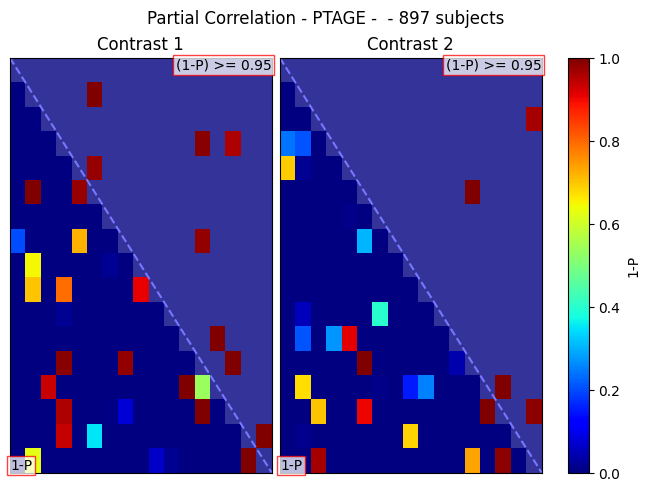

In [9]:
interest = 'P' # F = Full Correlation, P = Partial Correlation, A = Amplitude
type = interest

if interest == 'P':
    interest = Pnetmats
    title = 'Partial Correlation - ' + interest_var + ' - ' + group_var + ' - ' + str(N_subjects) + ' subjects'
elif interest == 'F':
    interest = Fnetmats
    title = 'Full Correlation - ' + interest_var + ' - ' + group_var + ' - ' + str(N_subjects) + ' subjects'
else:
    interest = Anetmats
    title = 'Amplitude - ' + interest_var + ' - ' + group_var + ' - ' + str(N_subjects) + ' subjects'

# Perform GLM with time series data, design matrix and contrast matrix and plot the results
plt.figure(constrained_layout=True)
p_corr, p_uncorr = nets.glm(ts, interest, name_file_design_mat, name_file_design_con, plot=True, title=title, nperms=permutations)
fig = plt.gcf()  # Get the current figure

# Show the plot
plt.show()  # Display the plot

if type == 'P':
    partial_pcorr = p_corr.copy()
    partial_puncorr = p_uncorr.copy()
elif type == 'F':
    full_pcorr = p_corr.copy()
    full_puncorr = p_uncorr.copy()
else:
    partial_pcorr = p_corr.copy()
    partial_puncorr = p_uncorr.copy()

68514

------------------
Contrast 1 [1 0 0]
------------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
18     | 19     | 5.115867    | 0.9998 
1      | 5      | 4.8393292   | 0.9998 
3      | 15     | 4.418109    | 0.9994 
6      | 15     | 4.032343    | 0.9984 
6      | 8      | 3.8663478   | 0.9964 
3      | 18     | 3.878972    | 0.9964 
1      | 8      | 3.5986981   | 0.991  
4      | 7      | 3.5129652   | 0.9882 
3      | 13     | 3.3762302   | 0.981  
6      | 9      | 3.2192688   | 0.9704 
1      | 9      | 3.0850537   | 0.9514 

-------------------
Contrast 2 [-1 0 0]
-------------------

Node i | Node j | T statistic | P value
------ | ------ | ----------- | -------
4      | 11     | 3.3400266   | 0.9812 
2      | 15     | 3.2962477   | 0.9776 


<Figure size 640x480 with 0 Axes>

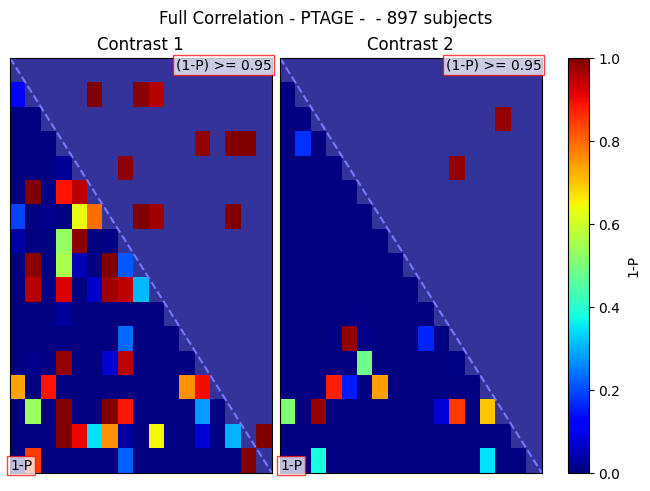

In [10]:
interest = 'F' # F = Full Correlation, P = Partial Correlation, A = Amplitude
type = interest

if interest == 'P':
    interest = Pnetmats
    title = 'Partial Correlation - ' + interest_var + ' - ' + group_var + ' - ' + str(N_subjects) + ' subjects'
elif interest == 'F':
    interest = Fnetmats
    title = 'Full Correlation - ' + interest_var + ' - ' + group_var + ' - ' + str(N_subjects) + ' subjects'
else:
    interest = Anetmats
    title = 'Amplitude - ' + interest_var + ' - ' + group_var + ' - ' + str(N_subjects) + ' subjects'

# Perform GLM with time series data, design matrix and contrast matrix and plot the results
plt.figure(constrained_layout=True)
p_corr, p_uncorr = nets.glm(ts, interest, name_file_design_mat, name_file_design_con, plot=True, title=title, nperms=permutations)
fig = plt.gcf()  # Get the current figure

# Show the plot
plt.show()  # Display the plot

if type == 'P':
    partial_pcorr = p_corr.copy()
    partial_puncorr = p_uncorr.copy()
elif type == 'F':
    full_pcorr = p_corr.copy()
    full_puncorr = p_uncorr.copy()
else:
    partial_pcorr = p_corr.copy()
    partial_puncorr = p_uncorr.copy()

In [11]:
# Find the indx of p_values above 0.95 (Significant results after correction)

idx = np.where(p_corr[1] > 0.95)[0]

tri = np.triu_indices(17, k=1)
flattened_idx = tri[0] * 17 + tri[1]

idx = [int(i) for i in idx if i in flattened_idx]

print(idx)

def given_nodes_get_idx(node1, node2, n=17):
    node1, node2 = sorted([node1, node2])
    node1 = goodnodes.index(node1)
    node2 = goodnodes.index(node2)
    tri = np.triu_indices(n, k=1)
    idx = node1 * n + node2
    return idx

[48, 79]


### Matrix Reorganization

In [12]:

def combine_upper_lower(upper_mat, lower_mat):
    """
    Combine two symmetric matrices (both 17x17):
      - Upper triangle (including diagonal) comes from 'upper_mat'
      - Lower triangle (below diagonal) comes from 'lower_mat'
    """
    # Make a copy of the lower_mat so we can overwrite the upper part
    combined = lower_mat.copy()
    # Fill in the upper triangle (including diagonal) from upper_mat
    # np.triu_indices_from(...) returns the indices for the upper triangle
    iu = np.triu_indices_from(upper_mat)
    combined[iu] = upper_mat[iu]
    # Set the diagonal to 0 (since it's duplicated in the upper_mat)
    np.fill_diagonal(combined, 0)
    return combined

# -------------------------------------------------
# Reshape all arrays from (2, 289) to two 17x17
# matrices for each condition
# -------------------------------------------------
# partial pcorr
partial_pcorr_m1 = partial_pcorr[0].reshape(17, 17)  # contrast 1
partial_pcorr_m2 = partial_pcorr[1].reshape(17, 17)  # contrast 2

# full pcorr
full_pcorr_m1 = full_pcorr[0].reshape(17, 17)        # contrast 1
full_pcorr_m2 = full_pcorr[1].reshape(17, 17)        # contrast 2

# partial puncorr
partial_puncorr_m1 = partial_puncorr[0].reshape(17, 17)  # contrast 1
partial_puncorr_m2 = partial_puncorr[1].reshape(17, 17)  # contrast 2

# full puncorr
full_puncorr_m1 = full_puncorr[0].reshape(17, 17)        # contrast 1
full_puncorr_m2 = full_puncorr[1].reshape(17, 17)        # contrast 2

# -------------------------------------------------
# Build the 4 combined 17x17 matrices:
# 1) pcorr contrast 1  => upper from partial_pcorr_m1, lower from full_pcorr_m1
# 2) pcorr contrast 2  => upper from partial_pcorr_m2, lower from full_pcorr_m2
# 3) puncorr contrast 1 => upper from partial_puncorr_m1, lower from full_puncorr_m1
# 4) puncorr contrast 2 => upper from partial_puncorr_m2, lower from full_puncorr_m2
# -------------------------------------------------
matrix_pcorr_1  = combine_upper_lower(partial_pcorr_m1,  full_pcorr_m1)
matrix_pcorr_2  = combine_upper_lower(partial_pcorr_m2,  full_pcorr_m2)
matrix_puncorr_1 = combine_upper_lower(partial_puncorr_m1, full_puncorr_m1)
matrix_puncorr_2 = combine_upper_lower(partial_puncorr_m2, full_puncorr_m2)

# Save the 4 matrices to download
save_mat = False

if save_mat: # Adjust the paths as necessary
    np.save('centiloid_matrix_pcorr_1.npy', matrix_pcorr_1)
    np.save('centiloid_matrix_pcorr_2.npy', matrix_pcorr_2)
    np.save('centiloid_matrix_puncorr_1.npy', matrix_puncorr_1)
    np.save('centiloid_matrix_puncorr_2.npy', matrix_puncorr_2)


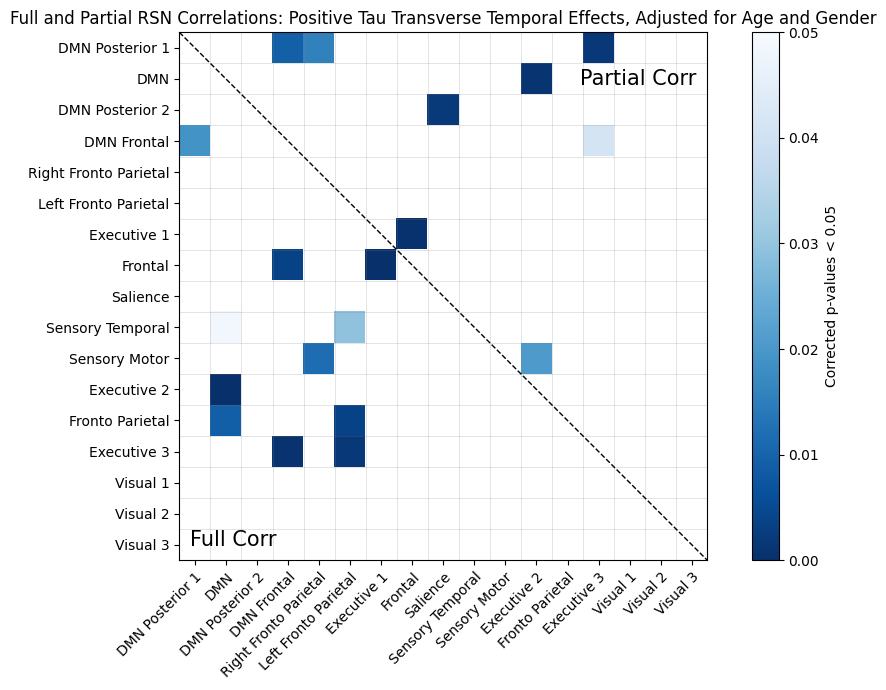

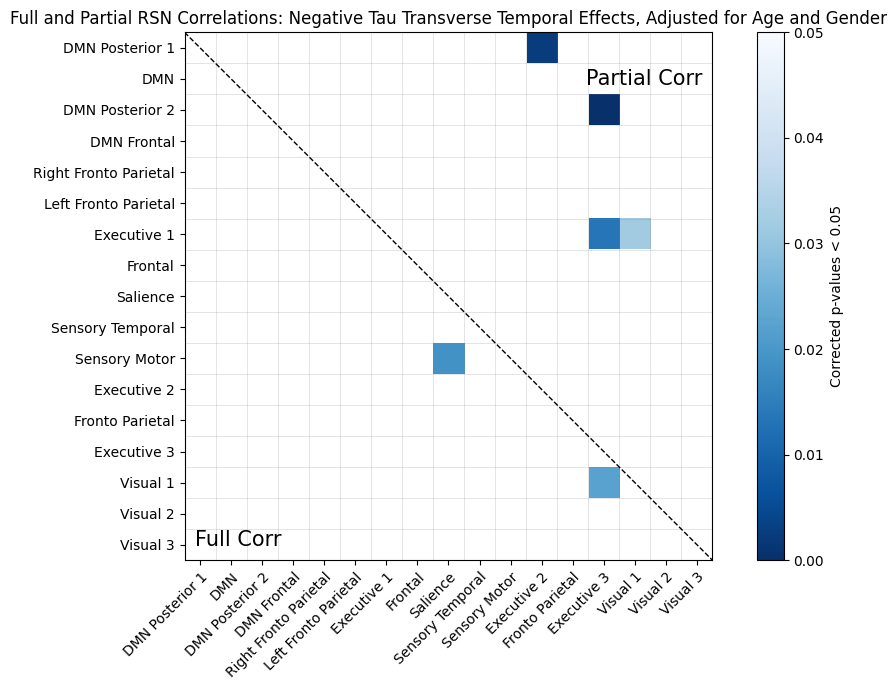

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def plot_thresholded_matrix_inverted(mat, title='', cmap='hot', order=False):
    """
    Plot a single 17x17 matrix in 'p-value style':
        - The input 'mat' is assumed to have 'inverted significance' values
          in [0.95..1], where 1 = p=0, 0.95 = p=0.05, etc.
        - We invert it via pvals = 1 - mat so that pvals are in [0..0.05].
        - Includes:
            * Grid lines (alpha=0.3)
            * Dashed black diagonal (linewidth=1)
            * Axis tick labels with network names (smaller font, x-axis rotated)
            * Two text labels: "Partial Corr" (top-right) & "Full Corr" (bottom-left)
        - Can reorder the matrix and labels to follow the network order.
        - Colorbar labeled 'Corrected p-values < 0.05'.

    Parameters
    ----------
    mat : 2D ndarray, shape (17,17)
        The matrix to plot, with "inverted significance" in [0.95..1].
    title : str
        Title to display on the plot.
    cmap : str
        Name of a matplotlib colormap (default 'hot').
    order : bool
        Whether to reorder the matrix and labels to follow network_order.
    """
    global goodnodes, correspondence, network_order

    # 1) Convert 'inverted significance' to normal p-values
    #    1.0 => p=0, 0.95 => p=0.05
    pvals = 1.0 - mat

    # 2) Threshold so only p < 0.05 are shown
    pvals_thr = np.where(pvals < 0.05, pvals, np.nan)

    # 3) Reorder matrix and labels if order=True
    if order:
        # Find the indices of the reordered nodes
        reorder_indices = [goodnodes.index(node) for node in network_order]

        # Create a new matrix to hold reordered values
        reordered_matrix = np.empty_like(pvals_thr) * np.nan

        # Reorder the upper triangle (partial correlations)
        for i, row_idx in enumerate(reorder_indices):
            for j, col_idx in enumerate(reorder_indices):
                if j > i:  # Upper triangle (partial correlations)
                    reordered_matrix[i, j] = pvals_thr[min(row_idx, col_idx), max(row_idx, col_idx)]

        # Reorder the lower triangle (full correlations)
        for i, row_idx in enumerate(reorder_indices):
            for j, col_idx in enumerate(reorder_indices):
                if j < i:  # Lower triangle (full correlations)
                    reordered_matrix[i, j] = pvals_thr[max(row_idx, col_idx), min(row_idx, col_idx)]

        # Use the reordered matrix for plotting
        pvals_thr = reordered_matrix

        # Reorder the labels to match the network_order
        labels = [correspondence[node] for node in network_order]
    else:
        labels = [correspondence[node] for node in goodnodes]



    # 4) Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 7))

    # 5) Plot the thresholded p-value matrix
    im = ax.imshow(
        pvals_thr,
        cmap=cmap,
        interpolation='nearest',
        origin='upper',
        vmin=0,      # darkest color for p=0
        vmax=0.05    # lightest color for p=0.05
    )

    # 6) Add colorbar labeled 'Corrected p-values < 0.05'
    cb = fig.colorbar(im, ax=ax)
    cb.set_label('Corrected p-values < 0.05')

    # 7) Major ticks: label them with network names (rotated on x-axis)
    ax.set_xticks(range(pvals_thr.shape[1]))
    ax.set_yticks(range(pvals_thr.shape[0]))
    ax.set_xticklabels(
        labels, 
        rotation=45, 
        rotation_mode='anchor', 
        ha='right',
        fontsize=10
    )
    ax.set_yticklabels(labels, fontsize=10)

    # Minor ticks at half-integer positions => grid lines
    ax.set_xticks(np.arange(pvals_thr.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(pvals_thr.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.tick_params(which='minor', bottom=False, left=False)

    # 8) Dashed black diagonal line
    ax.plot(
        [-0.5, pvals_thr.shape[0] - 0.5],
        [-0.5, pvals_thr.shape[1] - 0.5],
        color='black', linewidth=1, linestyle='--'
    )

    # 9) Add text annotations for partial & full corr
    #    - Coordinates below are in "axes fraction" (0..1).
    #      (0.98, 0.98) ~ top-right, (0.02, 0.02) ~ bottom-left
    ax.text(
        0.98, 0.93, "Partial Corr",
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=15, color='black'
    )
    ax.text(
        0.02, 0.02, "Full Corr",
        transform=ax.transAxes,
        ha='left', va='bottom',
        fontsize=15, color='black'
    )

    # 10) Title + tight layout
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

'''
matrix_pcorr_1 = np.load('centiloid_matrix_pcorr_1.npy')
matrix_pcorr_2 = np.load('centiloid_matrix_pcorr_2.npy')
matrix_puncorr_1 = np.load('centiloid_matrix_puncorr_1.npy')
matrix_puncorr_2 = np.load('centiloid_matrix_puncorr_2.npy')
'''

plot_thresholded_matrix_inverted(matrix_pcorr_1, 
                                 title='Full and Partial RSN Correlations: Positive Tau Transverse Temporal Effects, Adjusted for Age and Gender',
                                   cmap='Blues_r', order=True)

plot_thresholded_matrix_inverted(matrix_pcorr_2, 
                                 title='Full and Partial RSN Correlations: Negative Tau Transverse Temporal Effects, Adjusted for Age and Gender',
                                   cmap='Blues_r', order=True)


### Combination of positive and negative contrats into a single matrix

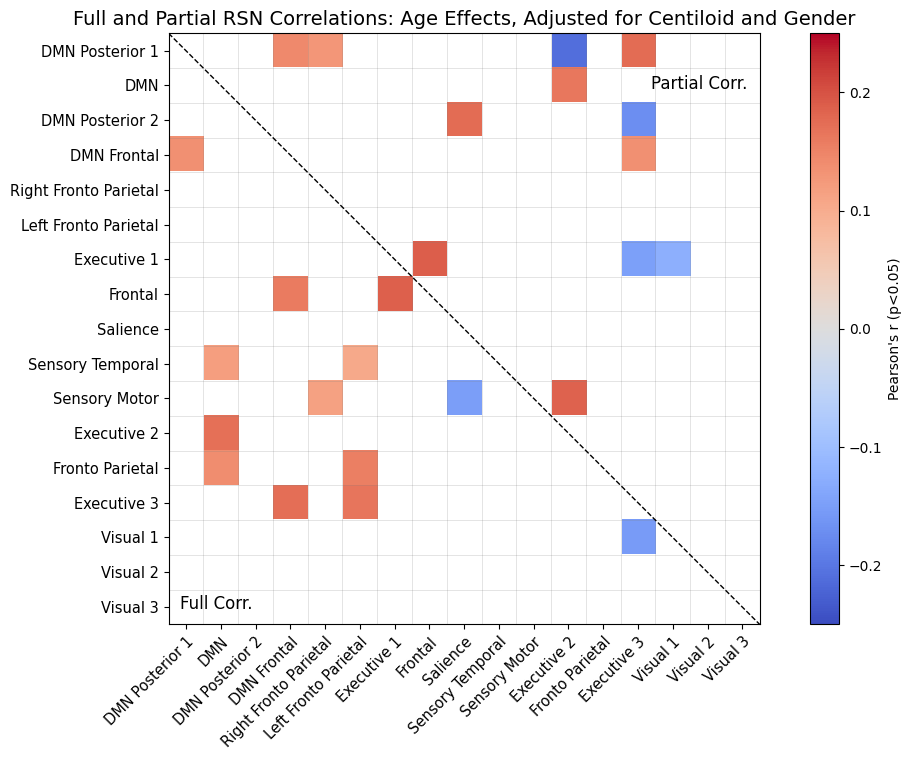

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def plot_thresholded_matrix_rvalues(
    pos_mat,
    neg_mat,
    df_csv,
    x_variable='PTAGE',
    title='',
    cmap='bwr',
    order=False,
    vmin=-1.0,
    vmax=+1.0
):
    """
    Plot a 17x17 matrix showing the Pearson's r-values for significant (p<0.05)
    positive or negative correlations, with partial correlations in the upper
    triangle and full correlations in the lower triangle.

    Parameters
    ----------
    pos_mat : 2D ndarray (17x17)
        'Inverted significance' for positive correlations ([0.95..1] => p<0.05).
    neg_mat : 2D ndarray (17x17)
        'Inverted significance' for negative correlations ([0.95..1] => p<0.05).
    df_csv : pandas.DataFrame
        Contains columns like 'fslnets_Pcorr_<pos>' or 'fslnets_Fcorr_<pos>'
        which we correlate with df_csv[x_variable].
    x_variable : str
        Name of the column in df_csv to correlate with each fslnets_... feature.
        Default is 'PTAGE'.
    title : str
        Plot title.
    cmap : str
        Colormap name (prefer a diverging map e.g. 'bwr', 'coolwarm', 'seismic').
    order : bool
        If True, reorder the matrix + labels with network_order instead of goodnodes order.
    vmin : float
        Minimum color scale value for the r-values plot (default -1.0).
    vmax : float
        Maximum color scale value for the r-values plot (default +1.0).

    Returns
    -------
    combined_r : 2D ndarray (17x17)
        Matrix of r-values (NaN where not significant).
    """

    # -------------------------------------------------------------------------
    # EXTERNAL references in your environment (for clarity only):
    #
    # goodnodes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13,14,15,18,19]
    #
    # network_order = [13,1,14,3,7,6,19,18,11,9,4,5,8,15,2,0,10]
    #
    # correspondence = {
    #   0:'Visual', 1:'DMN', 2:'Visual', 3:'DMN Frontal', 4:'Sensory Motor',
    #   5:'Executive', 6:'Left Fronto Parietal', 7:'Right Fronto Parietal',
    #   8:'Fronto Parietal', 9:'Sensory Temporal', 10:'Visual', 11:'Salience',
    #   13:'DMN Posterior', 14:'DMN Posterior', 15:'Executive', 18:'Frontal',
    #   19:'Executive'
    # }
    #
    # def given_nodes_get_idx(node1, node2, n=17):
    #     node1, node2 = sorted([node1, node2])
    #     node1 = goodnodes.index(node1)
    #     node2 = goodnodes.index(node2)
    #     # tri = np.triu_indices(n, k=1)  <-- Not actually used in your logic
    #     idx = node1 * n + node2
    #     return idx
    # -------------------------------------------------------------------------

    # Local copy of the DataFrame
    df_copy = df_csv.copy()

    # 1) Convert 'inverted significance' to normal p-values
    pos_pvals = 1.0 - pos_mat  # 1 => p=0, 0.95 => p=0.05
    neg_pvals = 1.0 - neg_mat

    # 2) Threshold => keep p<0.05, else NaN
    pos_thr = np.where(pos_pvals < 0.05, pos_pvals, np.nan)
    neg_thr = np.where(neg_pvals < 0.05, neg_pvals, np.nan)

    # We'll define a helper to compute correlation r for a given node pair
    # and whether it's partial or full correlation:
    def get_r_value(nodeA, nodeB, is_partial=True):
        """
        nodeA, nodeB => actual node labels from goodnodes (e.g. 13, 3, etc.)
        is_partial => True if partial correlation (upper triangle),
                      False if full correlation (lower triangle).
        """
        # 1) get the position index for fslnets_???_POS
        position = given_nodes_get_idx(nodeA, nodeB, n=17)

        # 2) column name
        if is_partial:
            colname = f'fslnets_Pcorr_{position}'
        else:
            colname = f'fslnets_Fcorr_{position}'

        # 3) correlation with x_variable
        if colname not in df_copy.columns:
            return np.nan

        return df_copy[colname].corr(df_copy[x_variable], method='pearson')

    # -------------------------------------------------------------------------
    # 3) Reorder the threshold matrices if order=True
    #    so that partial correlations are in the upper triangle, full in the lower.
    #    We'll create new arrays: reordered_pos, reordered_neg
    # -------------------------------------------------------------------------
    if order:
        reorder_indices = [goodnodes.index(n) for n in network_order]

        reordered_pos = np.full((17,17), np.nan)
        reordered_neg = np.full((17,17), np.nan)

        # Upper triangle => partial => (j>i)
        # Lower triangle => full => (j<i)
        for i, row_idx in enumerate(reorder_indices):
            for j, col_idx in enumerate(reorder_indices):
                if i == j:
                    continue

                if j > i:
                    # partial => upper triangle
                    # We pull from pos_thr[min,max] or neg_thr[min,max]
                    reordered_pos[i, j] = pos_thr[min(row_idx,col_idx), max(row_idx,col_idx)]
                    reordered_neg[i, j] = neg_thr[min(row_idx,col_idx), max(row_idx,col_idx)]
                else:
                    # full => lower triangle
                    reordered_pos[i, j] = pos_thr[max(row_idx,col_idx), min(row_idx,col_idx)]
                    reordered_neg[i, j] = neg_thr[max(row_idx,col_idx), min(row_idx,col_idx)]

        final_pos_thr = reordered_pos
        final_neg_thr = reordered_neg
        labels = [correspondence[node] for node in network_order]

    else:
        # No reorder => use pos_thr, neg_thr as is
        final_pos_thr = pos_thr
        final_neg_thr = neg_thr
        labels = [correspondence[node] for node in goodnodes]

    # -------------------------------------------------------------------------
    # 4) Build the combined_r matrix, scanning the final threshold arrays
    # -------------------------------------------------------------------------
    combined_r = np.full((17, 17), np.nan, dtype=float)

    for i in range(17):
        for j in range(17):
            if i == j:
                continue
            # If j>i => partial correlation
            # If j<i => full correlation
            is_partial = (j > i)

            # Check if positive correlation is significant
            if not np.isnan(final_pos_thr[i, j]):
                # Now figure out which nodes we're dealing with
                if order:
                    # i, j => row_idx, col_idx => reorder_indices[i], reorder_indices[j]
                    row_node = network_order[i]  # the actual node label
                    col_node = network_order[j]
                else:
                    row_node = goodnodes[i]
                    col_node = goodnodes[j]

                # Get the r-value
                r_val = get_r_value(row_node, col_node, is_partial=is_partial)
                combined_r[i, j] = r_val

            # Else check if negative correlation is significant
            elif not np.isnan(final_neg_thr[i, j]):
                if order:
                    row_node = network_order[i]
                    col_node = network_order[j]
                else:
                    row_node = goodnodes[i]
                    col_node = goodnodes[j]

                r_val = get_r_value(row_node, col_node, is_partial=is_partial)
                combined_r[i, j] = r_val

    # -------------------------------------------------------------------------
    # 5) Plot the matrix of r-values
    # -------------------------------------------------------------------------
    fig, ax = plt.subplots(figsize=(10*1.1, 7*1.1))

    im = ax.imshow(
        combined_r,
        cmap=cmap,
        interpolation='nearest',
        origin='upper',
        vmin=vmin,
        vmax=vmax
    )

    cb = fig.colorbar(im, ax=ax)
    cb.set_label("Pearson's r (p<0.05)")

    ax.set_xticks(range(17))
    ax.set_yticks(range(17))
    ax.set_xticklabels(labels, rotation=45, rotation_mode='anchor', ha='right', fontsize=10.5)
    ax.set_yticklabels(labels, fontsize=10.5)

    # Minor ticks => grid lines
    ax.set_xticks(np.arange(17+1)-0.5, minor=True)
    ax.set_yticks(np.arange(17+1)-0.5, minor=True)
    ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Dashed black diagonal
    ax.plot(
        [-0.5, 16.5],
        [-0.5, 16.5],
        color='black', linewidth=1, linestyle='--'
    )

    # Partial & Full annotations
    ax.text(
        0.98, 0.93, "Partial Corr.",
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=12, color='black'
    )
    ax.text(
        0.02, 0.02, "Full Corr.",
        transform=ax.transAxes,
        ha='left', va='bottom',
        fontsize=12, color='black'
    )

    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    plt.show()

    return combined_r


combined_r = plot_thresholded_matrix_rvalues(matrix_pcorr_1, matrix_pcorr_2, df_csv, x_variable='PTAGE',
                                title='Full and Partial RSN Correlations: Age Effects, Adjusted for Centiloid and Gender',
                                   cmap='coolwarm', order=True, vmax=0.25, vmin=-0.25)

### Data Visualization

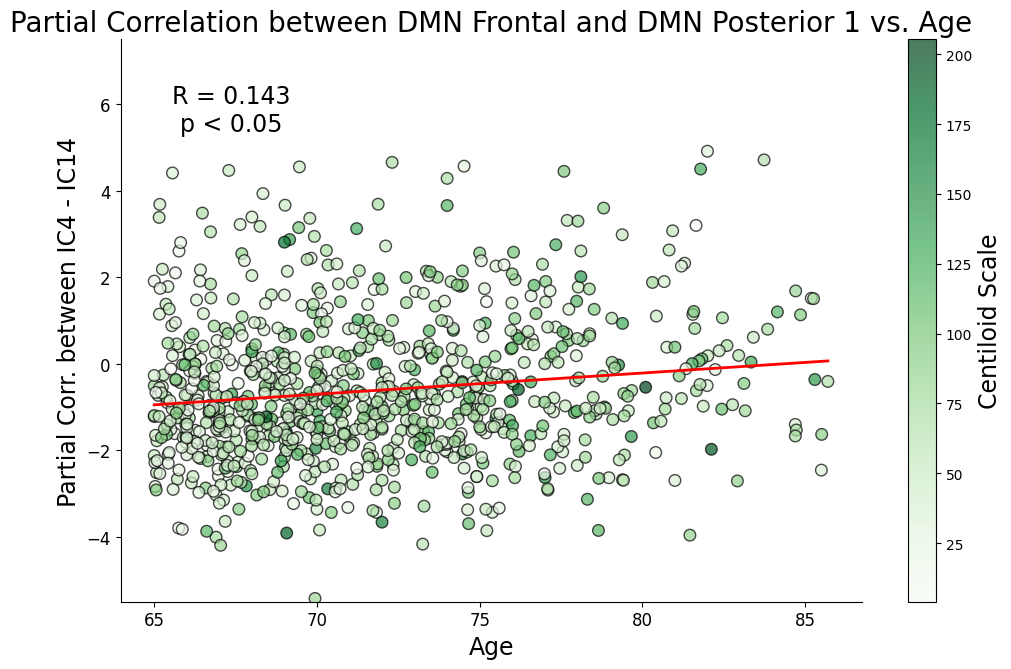

In [15]:


# Filter the DataFrame
datagraf2 = df_csv.copy()

# Define features
feature1 = 'PTAGE'  # X-axis
feature2 = 'fslnets_Pcorr_63'  # Y-axis
feature3 = 'centiloid'  # Color

# Create the scatter plot
plt.figure(figsize=(12*0.85, 8*0.85))
plt.scatter(
    datagraf2[feature1],
    datagraf2[feature2],
    c=datagraf2[feature3],
    cmap='Greens',
    alpha=0.7,
    edgecolors='k',
    s=70
)

# Add colorbar
cbar = plt.colorbar()
cbar.set_label('Centiloid Scale', fontsize=17)

# Axis labels and title
plt.xlabel('Age', fontsize=17)
plt.ylabel('Partial Corr. between IC4 - IC14', fontsize=17)
plt.title('Partial Correlation between DMN Frontal and DMN Posterior 1 vs. Age', fontsize=20)

# Add regression line
x_values = np.array(datagraf2[feature1])
y_values = np.array(datagraf2[feature2])
slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)

# Plot the line
x_line = np.linspace(x_values.min(), x_values.max(), 100)
y_line = slope * x_line + intercept
plt.plot(x_line, y_line, color='red', label='Best fit line', linewidth=2)

# Display R and p-value
plt.text(
    0.15, 0.9,
    f'R = {r_value:.3f}',
    ha='center',
    va='center',
    transform=plt.gca().transAxes,
    fontsize=17
)
if p_value < 0.05:
    plt.text(
        0.15, 0.85,
        'p < 0.05',
        ha='center',
        va='center',
        transform=plt.gca().transAxes,
        fontsize=17
    )
else:
    plt.text(
        0.15, 0.85,
        f'p = {p_value:.3f}',
        ha='center',
        va='center',
        transform=plt.gca().transAxes,
        fontsize=17
    )

# eliminate the top and right lines of the rectangle
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.ylim(-5.5, 7.5)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()
